# Traffic Flow Forecasting using LSTM and CNN-LSTM
This Colab notebook covers:
- Data preprocessing
- LSTM model
- CNN-LSTM model
- Real-time (simulated) traffic forecasting
- Evaluation metrics
- Visualization

In [ ]:
# Install dependencies (if not already installed)
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('traffic.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')
df = df[df['Junction'] == 1]  # Use Junction 1
df.set_index('DateTime', inplace=True)
data = df[['Vehicles']]

Saving traffic.csv to traffic.csv


In [ ]:
# Normalize & create sequences
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 24
X, y = create_sequences(scaled, seq_len)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM/CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32,
               validation_data=(X_test, y_test),
               callbacks=[EarlyStopping(patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.0121 - val_loss: 0.0051
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 6/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 8/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 9.7640e-04 - val_loss: 0.0019
Epoch 9/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 9.8687e-04 - val_loss: 0.0020
Epoch 10/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 9.5377e-04 - val_loss: 0.0016


In [ ]:
# CNN-LSTM model
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(LSTM(64))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(optimizer='adam', loss='mse')

cnn_lstm.fit(X_train, y_train, epochs=10, batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[EarlyStopping(patience=3)])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 0.0025


In [ ]:
# Evaluation and Prediction
def evaluate(model, X, y):
    pred = model.predict(X)
    pred = scaler.inverse_transform(pred)
    y_true = scaler.inverse_transform(y)
    return pred, y_true

lstm_pred, y_lstm = evaluate(lstm_model, X_test, y_test)
cnn_pred, y_cnn = evaluate(cnn_lstm, X_test, y_test)

print("LSTM RMSE:", np.sqrt(mean_squared_error(y_lstm, lstm_pred)))
print("CNN-LSTM RMSE:", np.sqrt(mean_squared_error(y_cnn, cnn_pred)))

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
LSTM RMSE: 6.130384783000358
CNN-LSTM RMSE: 7.5024052734395035


In [ ]:
# Real-time simulation (rolling forecast)
import random
last_seq = X_test[-1]
predictions = []

for i in range(10):  # simulate next 10 time steps
    next_pred = lstm_model.predict(last_seq.reshape(1, seq_len, 1))
    predictions.append(scaler.inverse_transform(next_pred)[0][0])
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = next_pred

print("Simulated Next 10 Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Simulated Next 10 Predictions: [np.float32(76.50729), np.float32(67.854065), np.float32(58.5734), np.float32(49.38597), np.float32(40.896847), np.float32(34.002182), np.float32(29.74412), np.float32(29.191353), np.float32(33.28959), np.float32(42.713512)]


In [14]:
# Plot Loss Curves
print("LSTM History Keys:", history.history.keys())
print("CNN-LSTM History Keys:", cnn_history.history.keys())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('CNN-LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

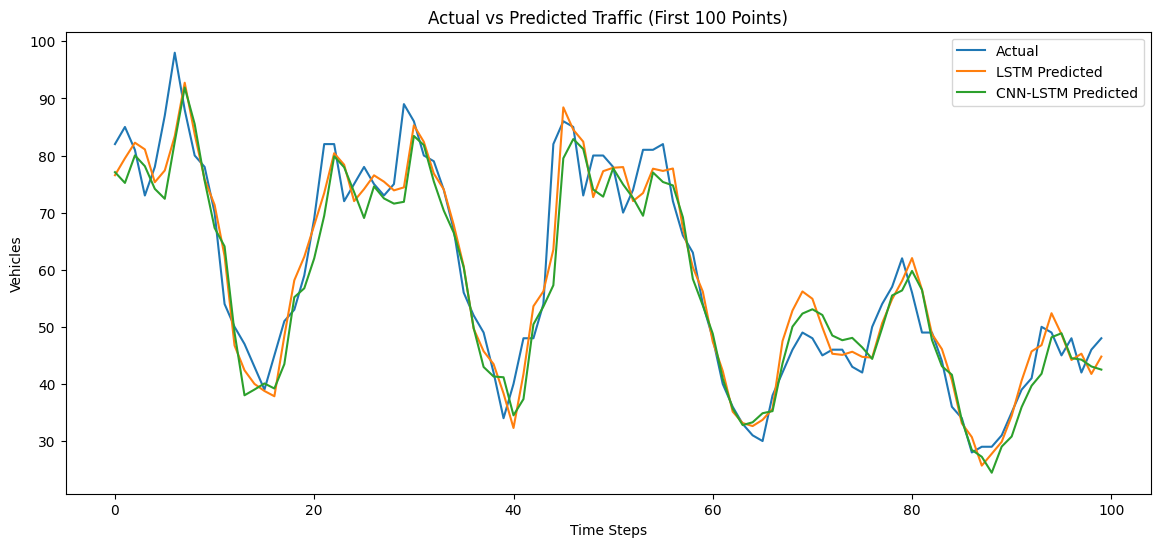

In [15]:
# Plot predicted vs actual traffic
plt.figure(figsize=(14,6))
plt.plot(y_lstm[:100], label='Actual')
plt.plot(lstm_pred[:100], label='LSTM Predicted')
plt.plot(cnn_pred[:100], label='CNN-LSTM Predicted')
plt.title('Actual vs Predicted Traffic (First 100 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

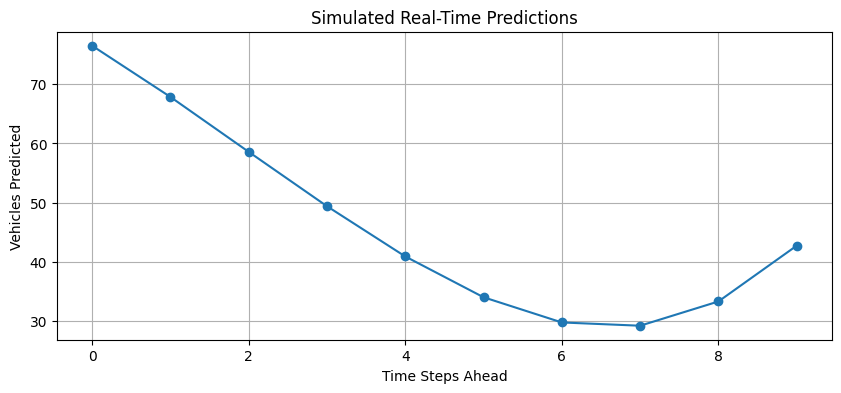

In [ ]:
# Plot simulated real-time predictions
plt.figure(figsize=(10,4))
plt.plot(predictions, marker='o')
plt.title('Simulated Real-Time Predictions')
plt.xlabel('Time Steps Ahead')
plt.ylabel('Vehicles Predicted')
plt.grid(True)
plt.show()